# Lap Times Complex Modeling

### load relevant libraries

In [27]:
#load libraries 
library(MASS)
install.packages("caret")
library(caret)
library(dplyr)
library(tidyverse)

The following package(s) will be installed:
- caret [7.0-1]
These packages will be installed into "~/renv/library/linux-ubuntu-jammy/R-4.4/x86_64-pc-linux-gnu".

# Installing packages --------------------------------------------------------
- Installing caret ...                          OK [linked from cache]


## Data Import & Cleaning 
Data was previously cleaned in Alteryx (file included in the files for this datalab)

In [28]:
#read in data for lap times
data <- read.csv("LapTimeVars.csv")
head(data)

,race_date,race_month,race_quarter,race_year,Time_of_Day,circ_name,location,country,driverRef,driver_age,driver_nation,Avg_lap_time,AvgPitDurationMS,Avg_stop,positionOrder,lap_limit,diff_lap,cons_name,cons_nation
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>
1,2021-12-05,12,4,2021,Afternoon,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,vettel,34,German,161813.40,1055527.000,1.5,16,50,6,Aston Martin,British
2,2022-03-27,3,1,2022,Afternoon,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,ocon,25,French,102306.20,21141.000,1.0,6,50,0,Alpine F1 Team,French
3,2021-12-05,12,4,2021,Afternoon,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,giovinazzi,27,Italian,152672.50,1049833.000,1.5,9,50,0,Alfa Romeo,Swiss
4,2024-03-09,3,1,2024,Afternoon,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,tsunoda,23,Japanese,98955.23,21694.000,1.0,15,50,1,RB F1 Team,Italian
5,2024-03-09,3,1,2024,Afternoon,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,ricciardo,34,Australian,99265.06,63364.000,1.0,16,50,1,RB F1 Team,Italian
6,2024-03-09,3,1,2024,Afternoon,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,gasly,28,French,121453.00,0.001,0.0,20,50,49,Alpine F1 Team,French


In [29]:
#make categorical column values as factors 
data[, c("race_month", "race_quarter", "circ_name", "location", "country", "driverRef", "driver_nation", "cons_name", "cons_nation")] <- lapply(data[, c("race_month", "race_quarter", "circ_name", "location", "country", "driverRef", "driver_nation", "cons_name", "cons_nation")], factor)

## Exploratory Data Analysis (some done in separate datalab to avoid confusion & long re-run times)

### Plots to check how predictors interact with lap time

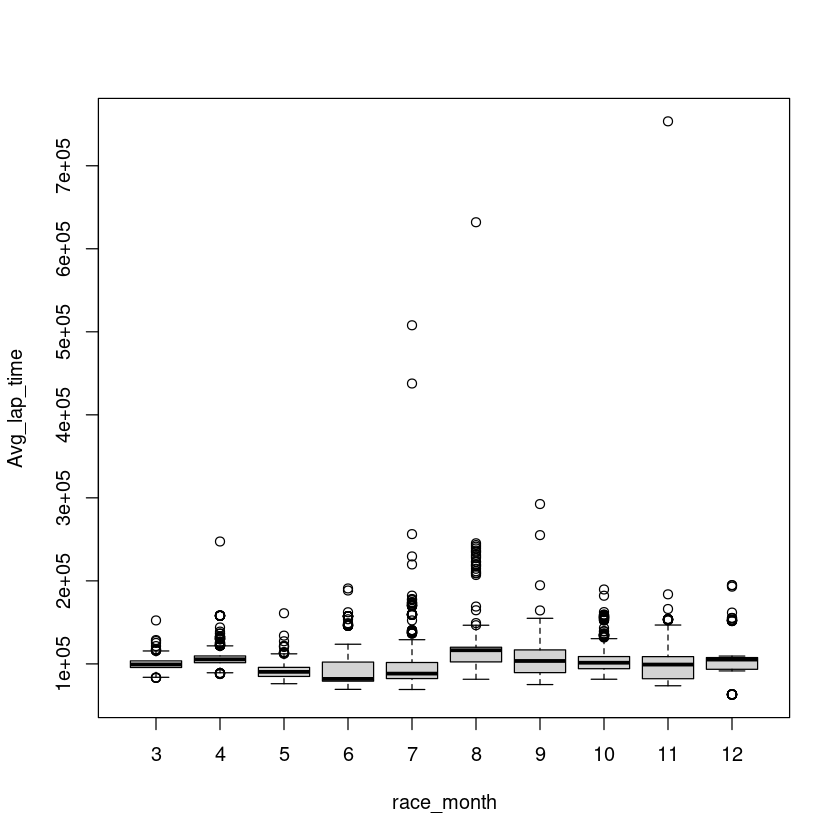

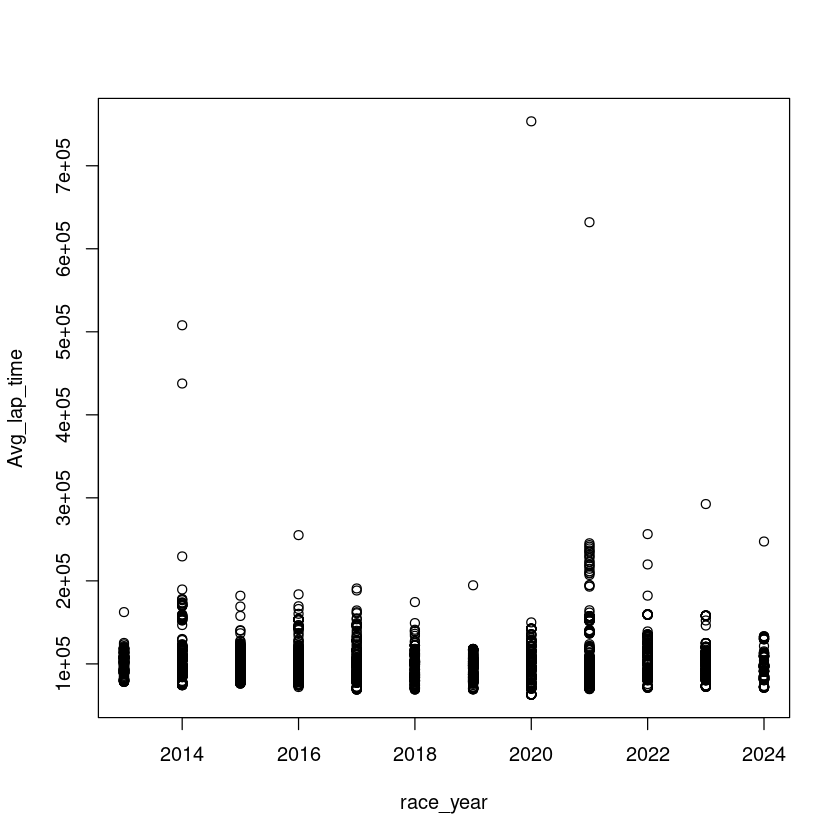

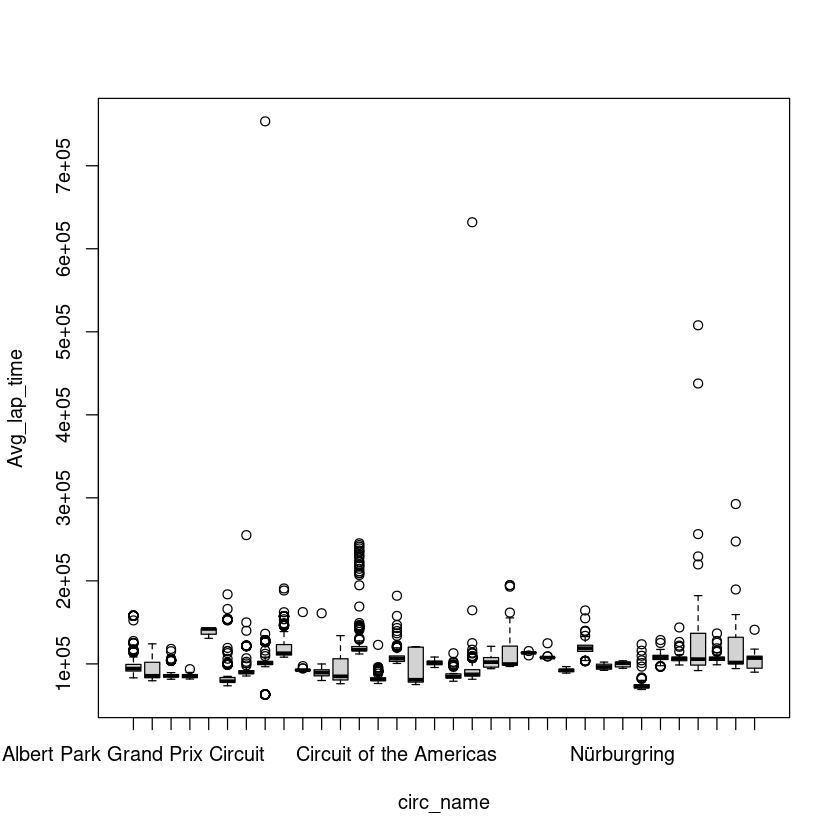

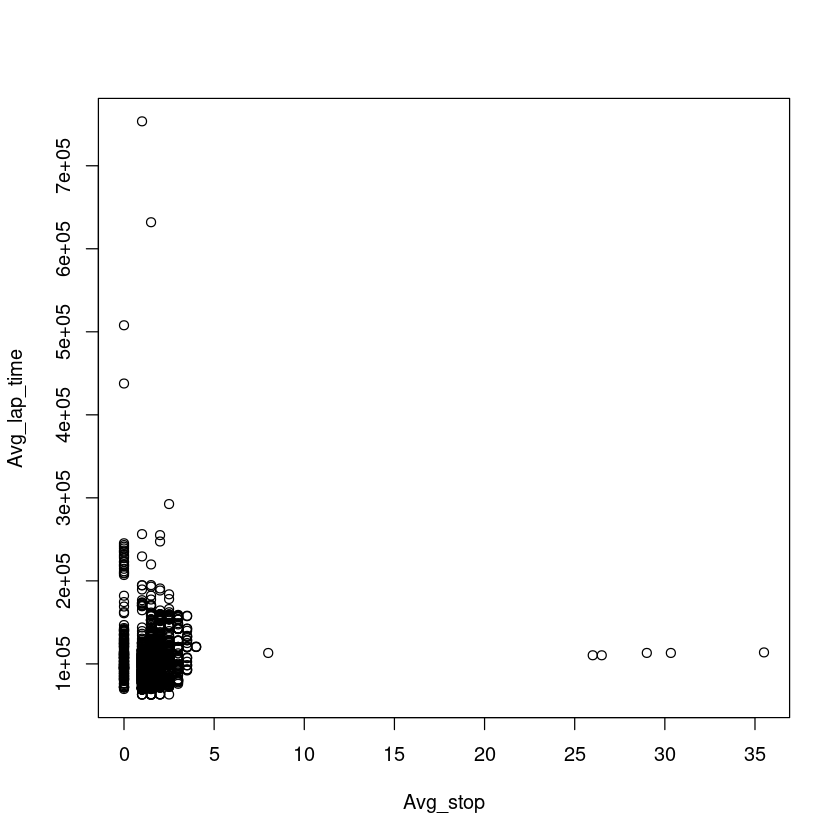

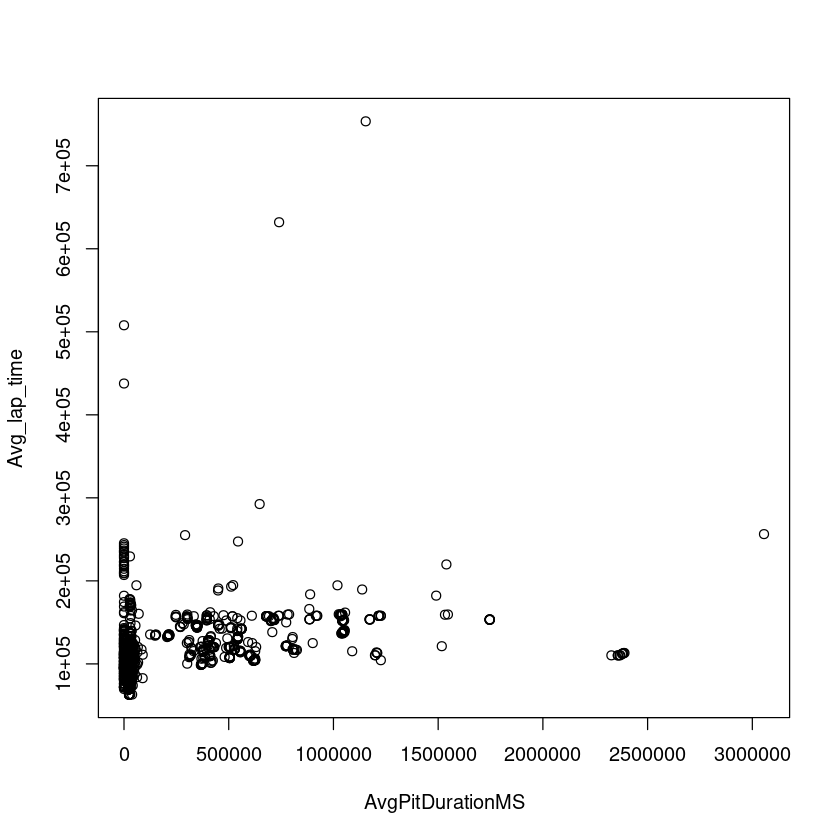

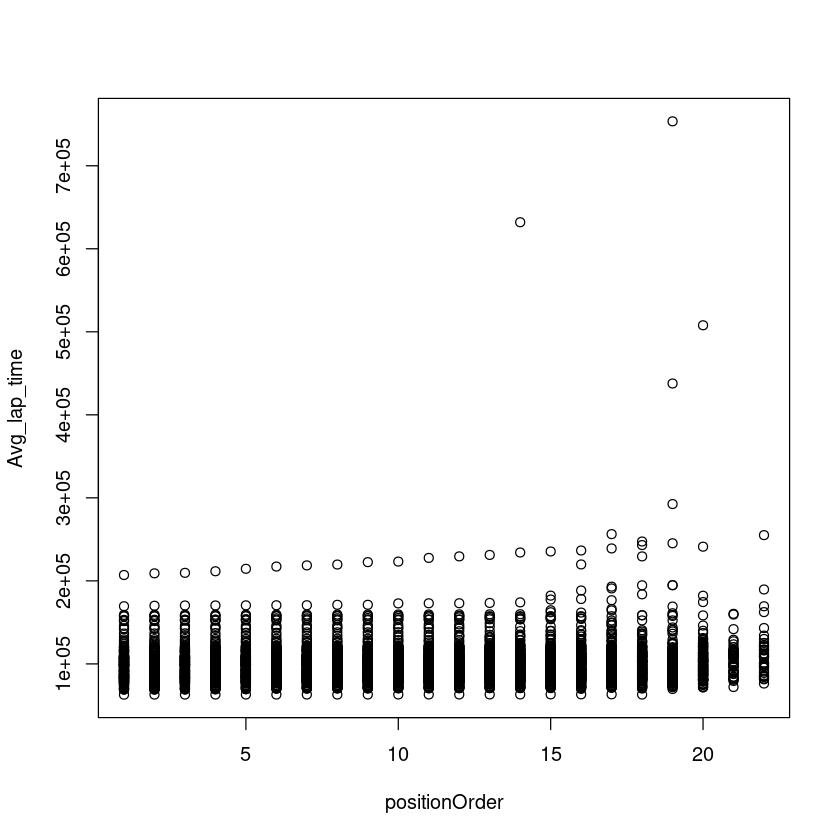

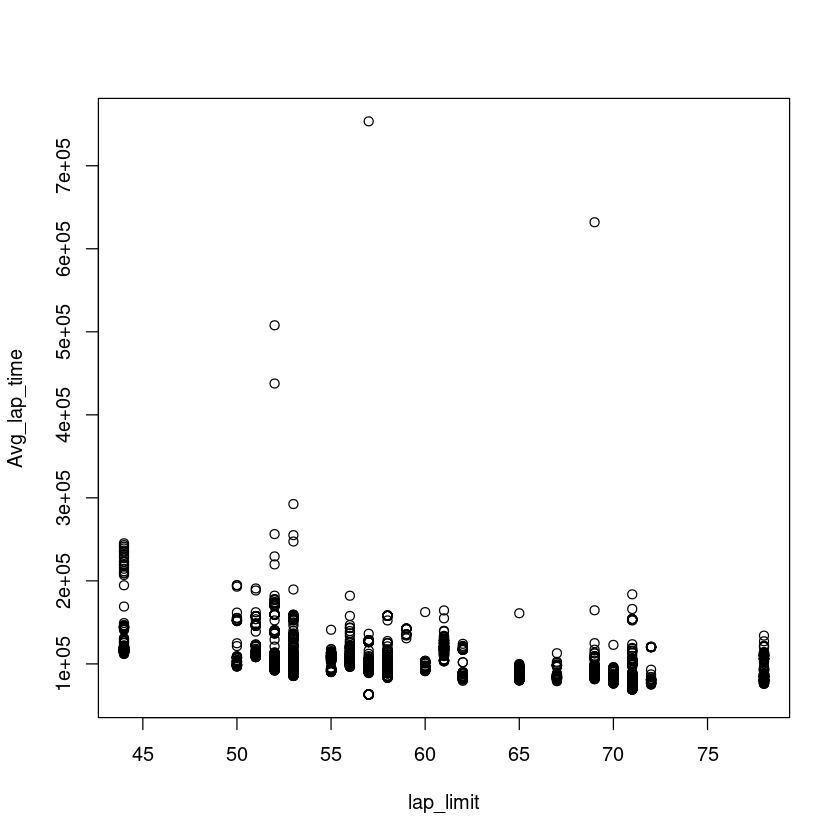

In [30]:
plot(Avg_lap_time ~ race_month, data = data)
plot(Avg_lap_time ~ race_year, data = data)
plot(Avg_lap_time ~ circ_name, data = data)
plot(Avg_lap_time ~ Avg_stop, data = data)
plot(Avg_lap_time ~ AvgPitDurationMS, data = data)
plot(Avg_lap_time ~ positionOrder, data = data)
plot(Avg_lap_time ~ lap_limit, data = data)

## Model Selection and Training

Chose a linear model beacuse other models were better for classification of set categories rather than the continuous variable (average lap times) we were trying to predict.

In [31]:
#set seed
set.seed(101)
#train & test split
train <- data %>% dplyr::filter(race_year >= 2013 & race_year <= 2023)
test <- data %>% dplyr::filter(race_year >= 2024)

In [32]:
lin <- lm(Avg_lap_time~ . - race_date, data = train)
lin_ori_sum <- summary(lin)
lin_ori_sum$adj.r.squared

[1] 0.5711063

## Feature Engineering

Create new features that may enhance the predictive power of the models. Discuss the rationale behind the feature selection and engineering process. (in code comments)

In [33]:
# Perform stepwise regression (both directions) to improve R squared values by adding/ dropping predictors
step_model <- step(lin, direction = "both")

# View the final model
step_mod_sum <- summary(step_model)
step_mod_sum$adj.r.squared

Start:  AIC=86443.93
Avg_lap_time ~ (race_date + race_month + race_quarter + race_year + 
    Time_of_Day + circ_name + location + country + driverRef + 
    driver_age + driver_nation + AvgPitDurationMS + Avg_stop + 
    positionOrder + lap_limit + diff_lap + cons_name + cons_nation) - 
    race_date


Step:  AIC=86443.93
Avg_lap_time ~ race_month + race_quarter + race_year + Time_of_Day + 
    circ_name + location + country + driverRef + driver_age + 
    driver_nation + AvgPitDurationMS + Avg_stop + positionOrder + 
    lap_limit + diff_lap + cons_name


Step:  AIC=86443.93
Avg_lap_time ~ race_month + race_quarter + race_year + Time_of_Day + 
    circ_name + location + country + driverRef + driver_age + 
    driver_nation + AvgPitDurationMS + Avg_stop + positionOrder + 
    diff_lap + cons_name


Step:  AIC=86443.93
Avg_lap_time ~ race_month + race_quarter + race_year + Time_of_Day + 
    circ_name + location + country + driverRef + driver_age + 
    AvgPitDurationMS + Avg_stop + po

[1] 0.5711718

In [34]:
#step & interaction - cons_name  & race_date b/c cons change all the time and the diff in r2 is minimal and date shouldn't be included as it is unique
step <- lm(Avg_lap_time ~ race_year + race_month + circ_name * AvgPitDurationMS * Avg_stop + positionOrder + diff_lap + driverRef, data = train)
step_sum <- summary(step)

step_sum$adj.r.squared

[1] 0.7583311

#### comments for performed transformations
tried polynomials & exponential & log-log & sqrt, but only led to minimal improvments in r2 and spread of residuals, chose to stick with what we had, with interactions between the circuit, average pit duration, and average number of stops. 

#### check normality of residuals & transform

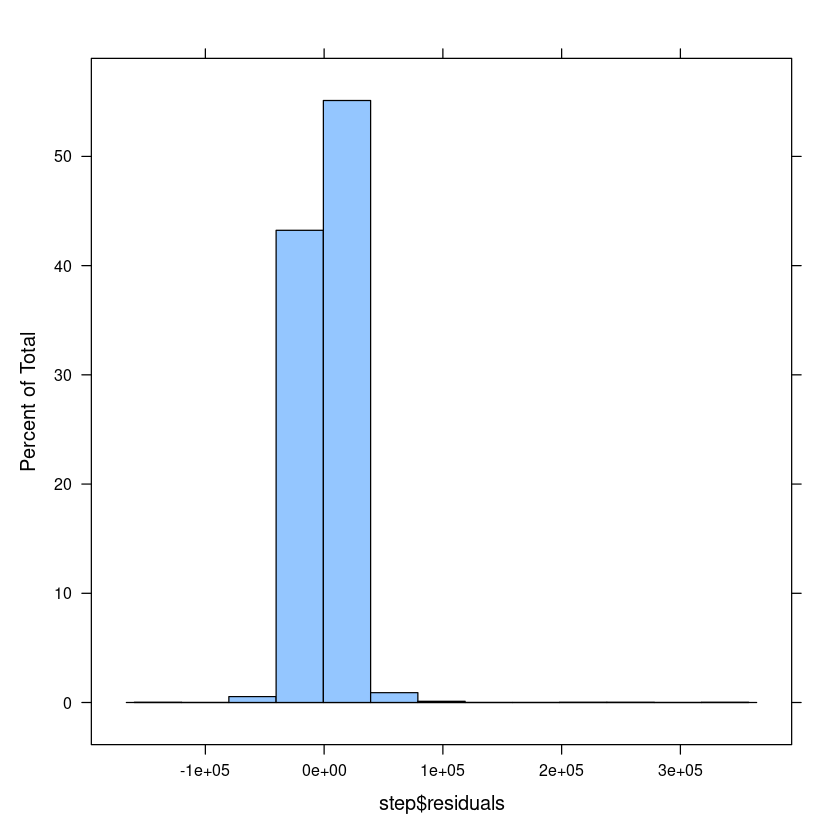

In [35]:
histogram(step$residuals)

transform tried exp (log(y)) first since heavy skew - no r2 was in 50s

#### plots for step interaction model 

Warning message:
“not plotting observations with leverage one:
  416, 4301”


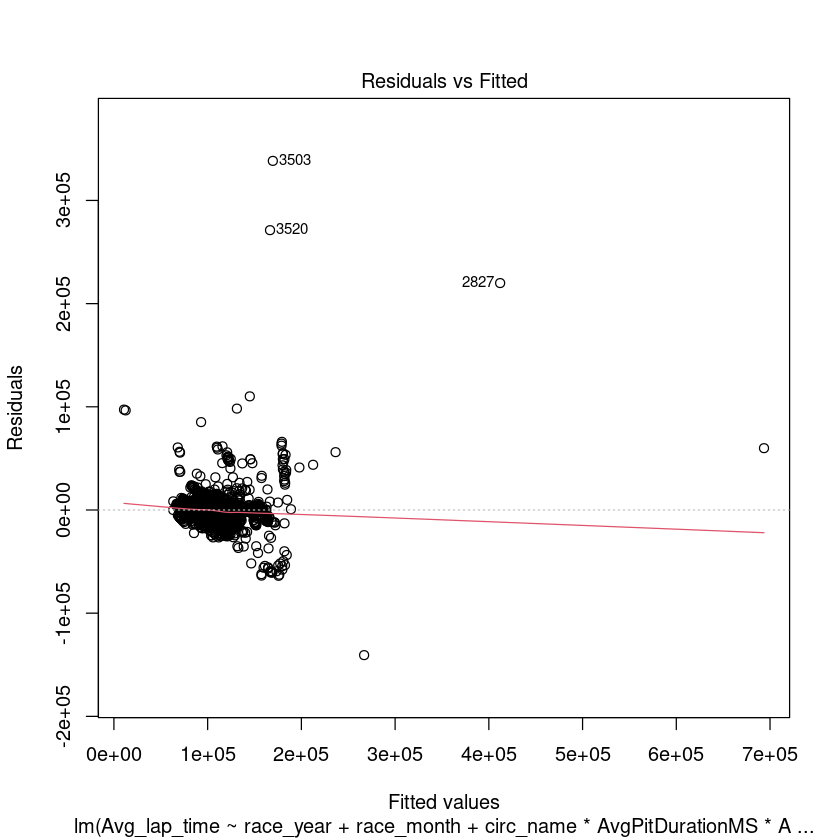

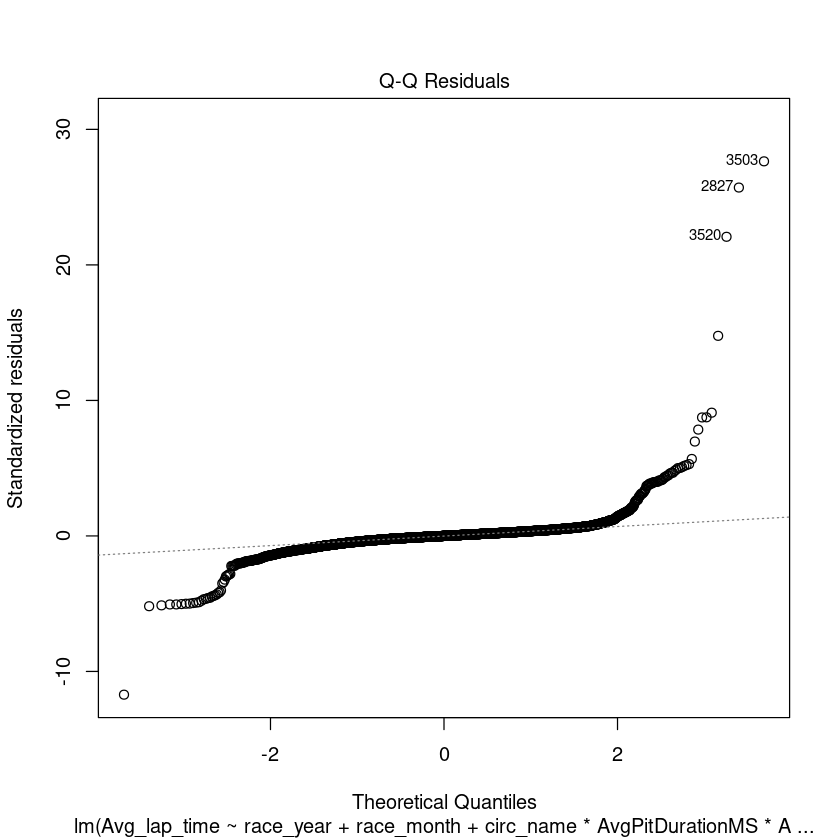

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


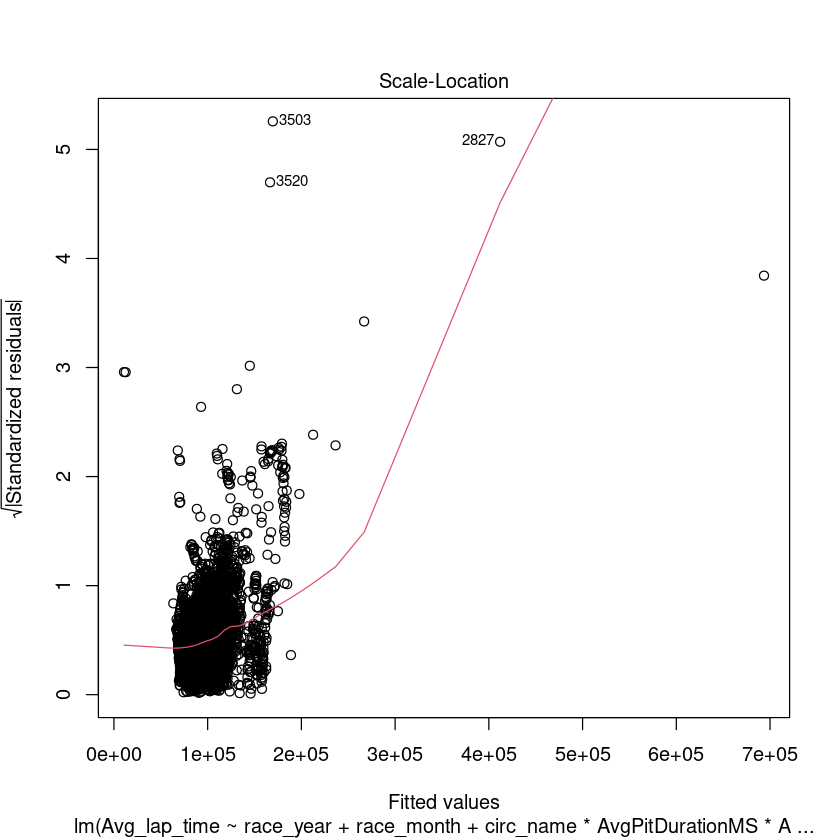

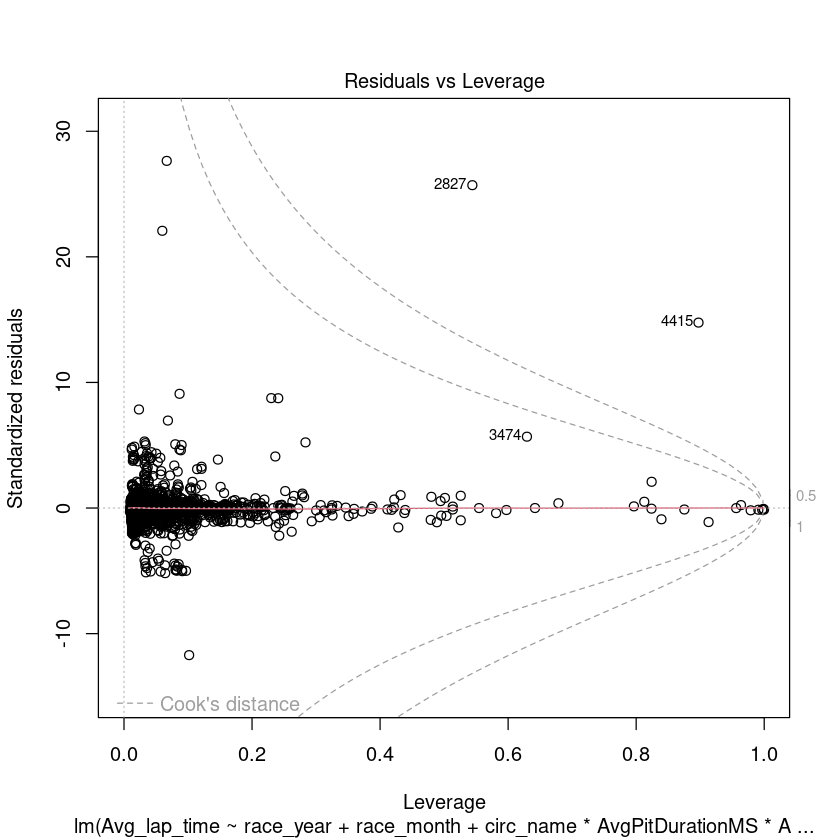

In [36]:
plot(step)

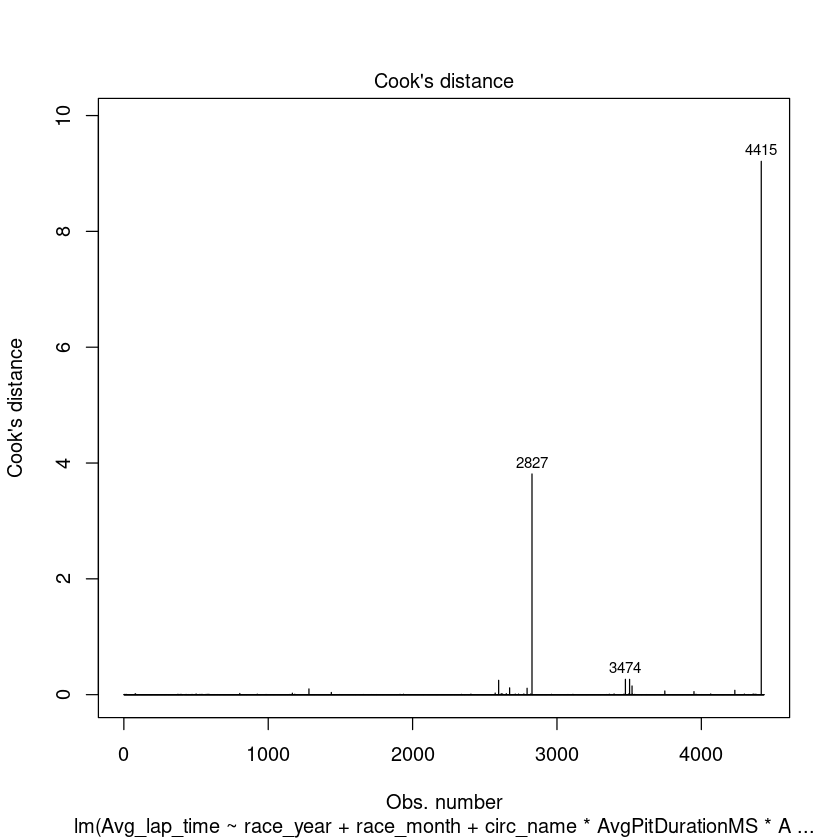

In [37]:
#plot cooks distance
plot(step, which = c(4))

In [53]:
out_out <- train[- c(2827,3503,4415), ]

In [54]:
# Fit the model again without outliers
step_out <- lm(Avg_lap_time ~ race_month + race_year + circ_name * AvgPitDurationMS * Avg_stop + positionOrder + diff_lap + driverRef, data = out_out)

step_out_sum  <- summary(step_out)

step_out_sum$adj.r.squared

[1] 0.7905299

### Model Evaluation

removing the outliers highlighted by our cooks distance and other plots does have a positive effect on the r squared of our model, therefore we will continue to use the outlier-less model

In [55]:
library(car)

car::vif(step_out, type = 'predictor')

GVIFs computed for predictors



,GVIF,Df,GVIF^(1/(2*Df)),Interacts With,Other Predictors
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
race_month,5.765431e+05,9,2.089518,--,"race_year, circ_name, AvgPitDurationMS, Avg_stop, positionOrder, diff_lap, driverRef"
race_year,2.505773e+00,1,1.582963,--,"race_month, circ_name, AvgPitDurationMS, Avg_stop, positionOrder, diff_lap, driverRef"
circ_name,6.738112e+06,135,1.059963,"AvgPitDurationMS, Avg_stop","race_month, race_year, positionOrder, diff_lap, driverRef"
AvgPitDurationMS,6.738112e+06,135,1.059963,"circ_name, Avg_stop","race_month, race_year, positionOrder, diff_lap, driverRef"
Avg_stop,6.738112e+06,135,1.059963,"circ_name, AvgPitDurationMS","race_month, race_year, positionOrder, diff_lap, driverRef"
positionOrder,2.456624e+00,1,1.567362,--,"race_month, race_year, circ_name, AvgPitDurationMS, Avg_stop, diff_lap, driverRef"
diff_lap,2.604708e+00,1,1.613911,--,"race_month, race_year, circ_name, AvgPitDurationMS, Avg_stop, positionOrder, driverRef"
driverRef,1.752210e+01,59,1.024563,--,"race_month, race_year, circ_name, AvgPitDurationMS, Avg_stop, positionOrder, diff_lap"


comfortable with this balance multi-colinearity (circ_name should be linked to stops and pit duration since each circut will require diff levels of each and it doesn't make sense to keep unattached to circuts since the circuts themselves aren't comparable (if our data included track length & turn numbers & turn degrees, I believe we could build a more comparable model without interaction terms))

In [41]:
install.packages("lmtest")
library(lmtest)

bptest(step_out)

The following package(s) will be installed:
- lmtest [0.9-40]
These packages will be installed into "~/renv/library/linux-ubuntu-jammy/R-4.4/x86_64-pc-linux-gnu".

# Installing packages --------------------------------------------------------
- Installing lmtest ...                         OK [linked from cache]



	studentized Breusch-Pagan test

data:  step_out
BP = 675.96, df = 206, p-value < 2.2e-16


pass the test, so have heteroskedasticity

### test model for lap times 2023-2024 data

In [42]:
#add bearman level to train
new_bearman <- test[test$driverRef == "bearman", ]

# Append the new row to the DataFrame
out_out <- rbind(out_out, new_bearman)

In [43]:
#redone with new bearman level in train
# Fit the model again without outliers
lin_br_out <- lm(Avg_lap_time ~ race_month + race_year + circ_name * Avg_stop * AvgPitDurationMS + positionOrder + diff_lap + driverRef, data = out_out)

lin_sum <- summary(lin_br_out)

lin_sum$adj.r.squared

[1] 0.747951

In [44]:
pred <- predict(lin_br_out, newdata= test)
head(pred)

1         2         3         4         5         6 
 99496.07  99298.10 101334.38  98310.79  99358.96  98640.26

In [45]:
actual <- test$Avg_lap_time
comp_df <- data.frame(Actual = actual, Prediction = pred)
comp_df

,Actual,Prediction
,<dbl>,<dbl>
1,98955.23,99496.07
2,99265.06,99298.10
3,121453.00,101334.38
4,98980.77,98310.79
5,97664.18,99358.96
6,96865.46,98640.26
7,98923.96,98127.68
8,97121.60,99254.08
9,97238.24,99636.60


### errors

In [46]:
MSE <- mean(((actual - pred)/1000)^2)
cat("MSE = ", MSE, "seconds\n")

MAE <- mean(abs((actual - pred)/1000))
cat("MAE = ", MAE, "seconds\n")

RMSE <- sqrt(MSE)
cat("RMSE = ", RMSE, "seconds\n")

MSE =  6354.369 seconds
MAE =  22.85978 seconds
RMSE =  79.71429 seconds


### lap times modeling for more recent races 2024

In [48]:
recent_2024 <- read.csv("2024Test.csv")

recent_2024

race_date,race_month,race_quarter,race_year,raceTime,circ_name,location,country,driverRef,AvgPitDurationMS,Avg_stop,positionOrder,lap_limit,diff_lap
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
2024-07-28,7,3,2024,13:00:00,Circuit de Spa-Francorchamps,Spa,Belgium,piastri,40668.63,1.548114,2,44,7.6635945
2024-10-27,10,4,2024,20:00:00,Autódromo Hermanos Rodríguez,Mexico City,Mexico,lawson,102462.10,1.280731,16,71,5.0000000
2024-09-15,9,3,2024,11:00:00,Baku City Circuit,Baku,Azerbaijan,bearman,133795.29,1.563750,10,51,5.0642857
2024-11-23,11,4,2024,06:00:00,Las Vegas Strip Street Circuit,Las Vegas,United States,lawson,23268.76,1.315789,16,50,2.8500000
2024-12-08,12,4,2024,13:00:00,Yas Marina Circuit,Abu Dhabi,UAE,lawson,22577.55,1.343874,17,55,2.4681818
2024-11-03,11,4,2024,17:00:00,Autódromo José Carlos Pace,São Paulo,Brazil,bearman,114204.36,1.896727,12,71,3.9218750
2024-11-03,11,4,2024,17:00:00,Autódromo José Carlos Pace,São Paulo,Brazil,lawson,114204.36,1.896727,9,71,3.9218750
2024-10-20,10,4,2024,19:00:00,Circuit of the Americas,Austin,USA,lawson,24953.65,1.362899,9,56,6.6050000
2024-09-01,9,3,2024,13:00:00,Autodromo Nazionale di Monza,Monza,Italy,leclerc,24077.83,1.166667,1,53,5.5000000


### Final Model Selection

In [56]:
newmod <- lm(Avg_lap_time ~ race_month + race_year + circ_name * Avg_stop * AvgPitDurationMS + positionOrder + diff_lap + driverRef, data = data) #includes all data 

newmod_sum <- summary(newmod) 

newmod_sum$adj.r.squared

[1] 0.7543731

In [57]:
# Convert race_month to a factor
recent_2024$race_month <- factor(recent_2024$race_month)

# Predict the average lap time for most recent races of 2024
pred2024 <- predict(newmod, newdata= recent_2024)
head(pred2024)

1         2         3         4         5         6 
122515.45  85756.58 118699.57 108223.42  97783.57  79115.11

### Summary of Findings

We found that our final model explained about 75% of the variability in the inital data, and generally overpredicted average lap time by about 23 seconds due to its sensitivity to outliers. While our model is great at capturing the average lap times of okay F1 drivers, it tends to over and underpredict the average lap times of really good F1 drivers and really bad ones, respectively. 

Below are the predictions for average lap time that our model generated for the most recent 2024 race, as well as the average prediction for all the 2024 races. Keep in mind that because we didn't have the data at the time of creating the model these predictions cannot be compared against available data quite yet due the lap times being an average and not a prediction for the fastest lap time.

Essentially these predictions are meant to act as a benchmark metric for racers to strive to reach above or remain within for better, more steady racing performances. 

##### most recent race predictions

In [51]:
pred_df <- data.frame(RaceDate = recent_2024$race_date, Driver = recent_2024$driverRef, Prediction = pred2024/60000)
pred_df[pred_df$RaceDate == "2024-12-08", ]

,RaceDate,Driver,Prediction
,<chr>,<chr>,<dbl>
5,2024-12-08,lawson,1.629726
41,2024-12-08,perez,1.614066
53,2024-12-08,russell,1.682049
58,2024-12-08,stroll,1.612987
120,2024-12-08,albon,1.604207
133,2024-12-08,hulkenberg,1.629832
138,2024-12-08,leclerc,1.612363
154,2024-12-08,sainz,1.670356
159,2024-12-08,zhou,1.650558


In [52]:
avg_prediction <- pred_df %>%
  group_by(Driver) %>%
  summarize(AveragePrediction = mean(Prediction, na.rm = TRUE))

avg_prediction

Driver,AveragePrediction
<chr>,<dbl>
albon,1.621672
alonso,1.698001
bearman,1.648456
bottas,1.623899
gasly,1.714409
hamilton,1.625152
hulkenberg,1.703803
kevin_magnussen,1.651986
lawson,1.580292
